In [1]:
pip install yfinance

In [2]:
import yfinance as yf

# Download historical data for Apple (AAPL)
data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")

data.to_csv("AAPL_stock_data.csv")

print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.716080  72.776606  71.466820  71.721026  135480400
2020-01-03  72.009109  72.771737  71.783954  71.941321  146322800
2020-01-06  72.582909  72.621646  70.876075  71.127866  118387200
2020-01-07  72.241547  72.849224  72.021231  72.592594  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200


In [3]:
print(data.columns)

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque



In [5]:
# Load Stock Market Data
def get_stock_data(ticker, start='2020-01-01', end='2024-01-01'):
    data = yf.download(ticker, start=start, end=end)
    data['Return'] = data['Close'].pct_change()
    data.dropna(inplace=True)
    return data

data = get_stock_data('AAPL')



[*********************100%***********************]  1 of 1 completed


In [6]:
print(data.columns)

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL'),
            ('Return',     '')],
           names=['Price', 'Ticker'])


In [7]:

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)





In [8]:
class TDQN_Agent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.model(state)).item()

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(torch.FloatTensor(next_state).unsqueeze(0))).item()
            target_f = self.model(torch.FloatTensor(state).unsqueeze(0))
            target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(self.model(torch.FloatTensor(state).unsqueeze(0)), target_f)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay




In [9]:
import matplotlib.pyplot as plt

def train_agent(agent, data, episodes=50):
    state_dim = len(data.columns)
    action_dim = 3  # 0: Hold, 1: Buy, 2: Sell
    episode_rewards = []  # Track total rewards per episode

    for episode in range(episodes):
        state = data.iloc[0].values
        total_reward = 0
        for i in range(1, len(data)):
            action = agent.act(state)
            next_state = data.iloc[i].values
            reward = data['Return'].iloc[i] if action == 1 else -data['Return'].iloc[i]
            done = i == len(data) - 1
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                print(f"Episode {episode+1}/{episodes}, Reward: {total_reward:.2f}")
                episode_rewards.append(total_reward)  # Store episode reward
        agent.replay()

    # Plot Training Rewards
    plt.plot(episode_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Training Performance')
    plt.show()



Episode 1/50, Reward: 0.48
Episode 2/50, Reward: -0.49
Episode 3/50, Reward: -1.01
Episode 4/50, Reward: -0.68
Episode 5/50, Reward: -0.81
Episode 6/50, Reward: -1.18
Episode 7/50, Reward: -0.00
Episode 8/50, Reward: 0.28
Episode 9/50, Reward: -1.43
Episode 10/50, Reward: 0.75
Episode 11/50, Reward: -1.56
Episode 12/50, Reward: -0.51
Episode 13/50, Reward: -1.83
Episode 14/50, Reward: -0.63
Episode 15/50, Reward: 1.26
Episode 16/50, Reward: -0.41
Episode 17/50, Reward: -0.27
Episode 18/50, Reward: -0.65
Episode 19/50, Reward: -1.13
Episode 20/50, Reward: -1.86
Episode 21/50, Reward: 0.43
Episode 22/50, Reward: 0.03
Episode 23/50, Reward: -0.43
Episode 24/50, Reward: -0.40
Episode 25/50, Reward: -0.56
Episode 26/50, Reward: -0.52
Episode 27/50, Reward: -0.53
Episode 28/50, Reward: -0.55
Episode 29/50, Reward: 0.47
Episode 30/50, Reward: -0.92
Episode 31/50, Reward: -0.94
Episode 32/50, Reward: -0.66
Episode 33/50, Reward: 0.35
Episode 34/50, Reward: -1.06
Episode 35/50, Reward: -0.44
Ep

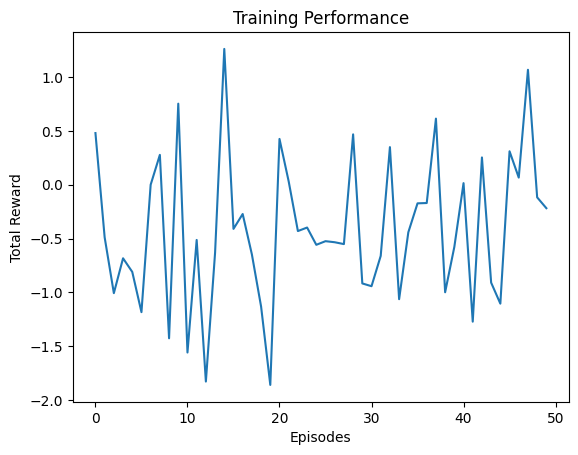

In [10]:
tdqn_agent = TDQN_Agent(state_dim=len(data.columns), action_dim=3)
train_agent(tdqn_agent, data)

Final Portfolio Value: $17548.25
Cumulative Return: 0.7548
Sharpe Ratio: 0.8990


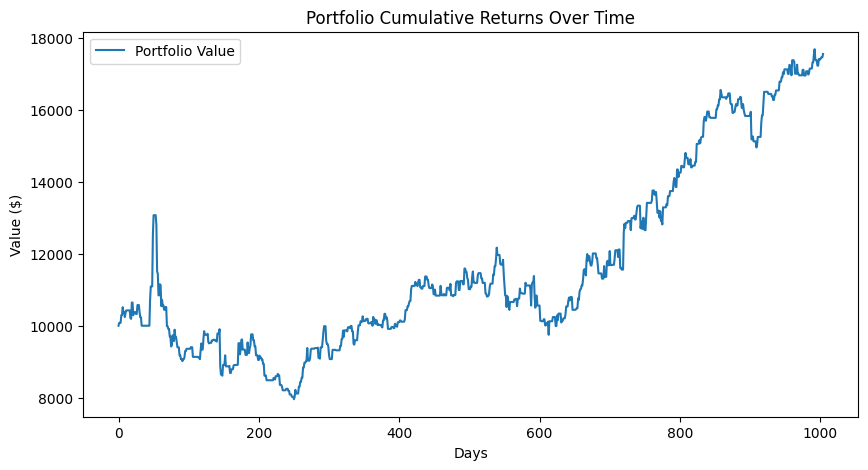

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def test_agent(agent, test_data, initial_balance=10000):
    state = test_data.iloc[0].values  # Initial state
    balance = initial_balance
    portfolio_value = [balance]
    daily_returns = []

    for i in range(1, len(test_data)):
        action = agent.act(state)  # Get action from the trained agent
        next_state = test_data.iloc[i].values
        price_change = test_data['Return'].iloc[i]

        if action == 1:  # Buy
            balance *= (1 + price_change)
        elif action == 2:  # Sell
            balance *= (1 - price_change)

        portfolio_value.append(balance)
        daily_returns.append(price_change)
        state = next_state  # Move to the next state


    cumulative_return = (portfolio_value[-1] - initial_balance) / initial_balance


    sharpe_ratio = np.mean(daily_returns) / (np.std(daily_returns) + 1e-8) * np.sqrt(252)  # Annualized


    print(f"Final Portfolio Value: ${portfolio_value[-1]:.2f}")
    print(f"Cumulative Return: {cumulative_return:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_value, label="Portfolio Value")
    plt.xlabel("Days")
    plt.ylabel("Value ($)")
    plt.title("Portfolio Cumulative Returns Over Time")
    plt.legend()
    plt.show()


test_agent(tdqn_agent, data)


In [15]:
#testing on tesla dataset
import pandas as pd

new_data = pd.read_csv('/content/TSLA.csv')

print(new_data.head())


        Date   Open   High    Low  Close    Volume
0  6/29/2010  3.800  5.000  3.508  4.778  93831500
1  6/30/2010  5.158  6.084  4.660  4.766  85935500
2   7/1/2010  5.000  5.184  4.054  4.392  41094000
3   7/2/2010  4.600  4.620  3.742  3.840  25699000
4   7/6/2010  4.000  4.000  3.166  3.222  34334500


In [16]:

new_data['Date'] = pd.to_datetime(new_data['Date'])


new_data = new_data.sort_values('Date')

new_data['Return'] = new_data['Close'].pct_change()
new_data.dropna(inplace=True)  # Remove NaN values

print(new_data.head())


        Date   Open   High    Low  Close    Volume    Return
1 2010-06-30  5.158  6.084  4.660  4.766  85935500 -0.002512
2 2010-07-01  5.000  5.184  4.054  4.392  41094000 -0.078473
3 2010-07-02  4.600  4.620  3.742  3.840  25699000 -0.125683
4 2010-07-06  4.000  4.000  3.166  3.222  34334500 -0.160937
5 2010-07-07  3.280  3.326  2.996  3.160  34608500 -0.019243


In [17]:
import pandas as pd

def compute_sma_ema(test_data, sma_period=10, ema_period=10):
    test_data['SMA'] = test_data['Close'].rolling(window=sma_period).mean()
    test_data['EMA'] = test_data['Close'].ewm(span=ema_period, adjust=False).mean()

    # Drop NaN values caused by rolling window
    return test_data.dropna().reset_index(drop=True)


In [18]:
new_datas = compute_sma_ema(new_data, sma_period=10, ema_period=10)

In [19]:
print(new_datas.head())

        Date   Open  High    Low  Close    Volume    Return     SMA       EMA
0 2010-07-14  3.588  4.03  3.552  3.968  20976000  0.093716  3.7358  3.808457
1 2010-07-15  3.988  4.30  3.800  3.978  18699000  0.002520  3.6570  3.839283
2 2010-07-16  4.140  4.26  4.010  4.128  13106500  0.037707  3.6306  3.891777
3 2010-07-19  4.274  4.45  4.184  4.382  12432500  0.061531  3.6848  3.980908
4 2010-07-20  4.370  4.37  4.010  4.060   9126500 -0.073482  3.7686  3.995289


In [20]:
def tests_agent(agent, test_data, initial_balance=10000):
    state = test_data.iloc[0].values.astype(np.float32)  # Convert to float32
    balance = initial_balance
    portfolio_value = [balance]
    daily_returns = []

    for i in range(1, len(test_data)):
        action = agent.act(state)
        next_state = test_data.iloc[i].values.astype(np.float32)  # Convert to float32
        price_change = test_data['Return'].iloc[i]

        if action == 1:  # Buy
            balance *= (1 + price_change)
        elif action == 2:  # Sell
            balance *= (1 - price_change)

        portfolio_value.append(balance)
        daily_returns.append(price_change)
        state = next_state  # Move to the next state

    cumulative_return = (portfolio_value[-1] - initial_balance) / initial_balance


    sharpe_ratio = np.mean(daily_returns) / (np.std(daily_returns) + 1e-8) * np.sqrt(252)  # Annualized

    print(f"Final Portfolio Value: ${portfolio_value[-1]:.2f}")
    print(f"Cumulative Return: {cumulative_return:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_value, label="Portfolio Value")
    plt.xlabel("Days")
    plt.ylabel("Value ($)")
    plt.title("Portfolio Cumulative Returns Over Time")
    plt.legend()
    plt.show()



In [21]:

selected_features = ["Close", "High", "Low", "Open", "Volume","Return"]  # Replace with actual column names

new_data = new_data[selected_features]

# Convert to float32 (to avoid dtype issues)
new_data = new_data.astype(np.float32)





In [22]:
print(new_data.columns)

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Return'], dtype='object')


Final Portfolio Value: $6403.20
Cumulative Return: -0.3597
Sharpe Ratio: 1.0905


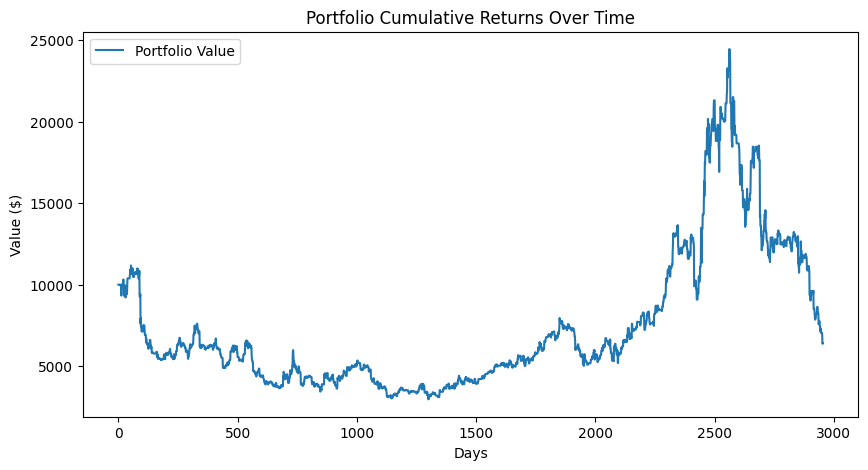

In [23]:
# Test TDQN Model on New Data
tests_agent(tdqn_agent, new_data)


In [24]:
#testing on hdfc dataset
# Load custom dataset (replace 'your_dataset.csv' with your actual file)
new_data_hdfc = pd.read_csv('/content/HDFCBANK.csv')

# Print first few rows to check the structure
print(new_data_hdfc.head())

         Date    Symbol Series  Prev Close    Open    High     Low    Last  \
0  2000-01-03  HDFCBANK     EQ      157.40  166.00  170.00  166.00  170.00   
1  2000-01-04  HDFCBANK     EQ      170.00  182.00  183.45  171.00  174.00   
2  2000-01-05  HDFCBANK     EQ      173.80  170.00  173.90  165.00  168.00   
3  2000-01-06  HDFCBANK     EQ      166.95  168.00  170.00  165.30  168.95   
4  2000-01-07  HDFCBANK     EQ      168.30  162.15  171.00  162.15  170.75   

    Close    VWAP  Volume      Turnover  Trades  Deliverable Volume  \
0  170.00  169.52   33259  5.638122e+11     NaN                 NaN   
1  173.80  174.99  168710  2.952261e+12     NaN                 NaN   
2  166.95  169.20  159820  2.704094e+12     NaN                 NaN   
3  168.30  168.44   85026  1.432166e+12     NaN                 NaN   
4  168.35  166.79   85144  1.420158e+12     NaN                 NaN   

   %Deliverble  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  


In [25]:
# Convert Date column to datetime format (if applicable)
new_data_hdfc['Date'] = pd.to_datetime(new_data_hdfc['Date'])

# Ensure it's sorted by date
new_data_hdfc = new_data_hdfc.sort_values('Date')

# Calculate Returns
new_data_hdfc['Return'] = new_data_hdfc['Close'].pct_change()
new_data_hdfc.dropna(inplace=True)  # Remove NaN values

print(new_data_hdfc.head())  # Check processed data

           Date    Symbol Series  Prev Close     Open     High      Low  \
2850 2011-06-01  HDFCBANK     EQ     2399.55  2390.00  2407.00  2374.75   
2851 2011-06-02  HDFCBANK     EQ     2398.20  2355.05  2366.70  2345.00   
2852 2011-06-03  HDFCBANK     EQ     2360.30  2359.95  2370.85  2348.50   
2853 2011-06-06  HDFCBANK     EQ     2356.75  2345.30  2390.00  2345.30   
2854 2011-06-07  HDFCBANK     EQ     2381.25  2365.10  2390.70  2363.80   

         Last    Close     VWAP  Volume      Turnover   Trades  \
2850  2404.95  2398.20  2397.60  657167  1.575623e+14  32536.0   
2851  2361.00  2360.30  2356.74  672276  1.584380e+14  33279.0   
2852  2364.00  2356.75  2358.69  598853  1.412506e+14  26661.0   
2853  2390.00  2381.25  2366.03  584280  1.382424e+14  22785.0   
2854  2374.60  2376.50  2377.48  406347  9.660803e+13  11760.0   

      Deliverable Volume  %Deliverble    Return  
2850            374167.0       0.5694 -0.000563  
2851            391660.0       0.5826 -0.015804  
28

In [38]:
def tests_agent_hdfc(agent, test_data, initial_balance=10000):
    state = test_data.iloc[0].values.astype(np.float32)  # Convert to float32
    balance = initial_balance
    portfolio_value = [balance]
    daily_returns = []

    for i in range(1, len(test_data)):
        action = agent.act(state)  # Get action from trained agent
        next_state = test_data.iloc[i].values.astype(np.float32)  # Convert to float32
        price_change = test_data['Return'].iloc[i]

        if action == 1:  # Buy
            balance *= (1 + price_change)
        elif action == 2:  # Sell
            balance *= (1 - price_change)

        portfolio_value.append(balance)
        daily_returns.append(price_change)
        state = next_state  # Move to the next state

    cumulative_return = (portfolio_value[-1] - initial_balance) / initial_balance

    sharpe_ratio = np.mean(daily_returns) / (np.std(daily_returns) + 1e-8) * np.sqrt(252)  # Annualized

    print(f"Final Portfolio Value: ${portfolio_value[-1]:.2f}")
    print(f"Cumulative Return: {cumulative_return:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_value, label="Portfolio Value")
    plt.xlabel("Days")
    plt.ylabel("Value ($)")
    plt.title("Portfolio Cumulative Returns Over Time")
    plt.legend()
    plt.show()

In [39]:
# Get the correct feature names from training data
selected_features = ["Close", "High", "Low", "Open", "Volume","Return"]  # Replace with actual column names

# Ensure test data has the same features
new_data_hdfc = new_data_hdfc[selected_features]

# Convert to float32 (to avoid dtype issues)
new_data_hdfc = new_data_hdfc.astype(np.float32)

Final Portfolio Value: $1241.17
Cumulative Return: -0.8759
Sharpe Ratio: 0.1982


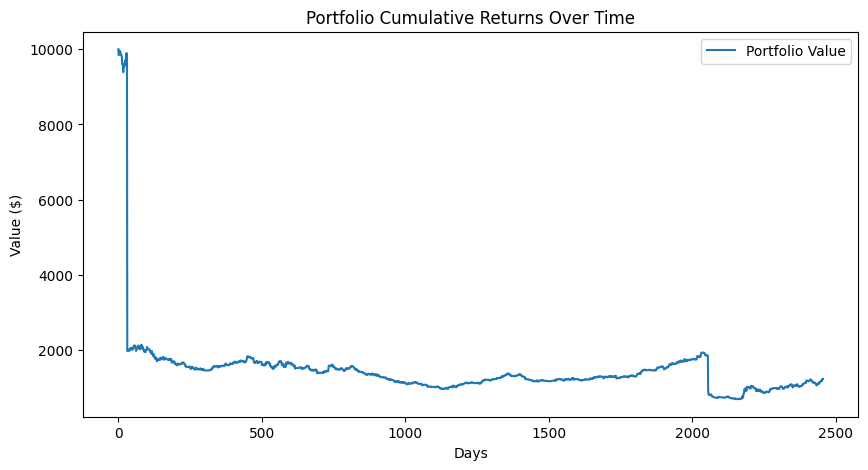

In [40]:
tests_agent_hdfc(tdqn_agent, new_data_hdfc)

In [41]:
# Load TCS dataset
new_data_tcs = pd.read_csv('/content/TCS.csv')

# Print first few rows to check the structure
print(new_data_tcs.head())

         Date Symbol Series  Prev Close    Open    High     Low    Last  \
0  2004-08-25    TCS     EQ      850.00  1198.7  1198.7  979.00  985.00   
1  2004-08-26    TCS     EQ      987.95   992.0   997.0  975.30  976.85   
2  2004-08-27    TCS     EQ      979.00   982.4   982.4  958.55  961.20   
3  2004-08-30    TCS     EQ      962.65   969.9   990.0  965.00  986.40   
4  2004-08-31    TCS     EQ      986.75   986.5   990.0  976.00  987.80   

    Close     VWAP    Volume      Turnover  Trades  Deliverable Volume  \
0  987.95  1008.32  17116372  1.725876e+15     NaN             5206360   
1  979.00   985.65   5055400  4.982865e+14     NaN             1294899   
2  962.65   969.94   3830750  3.715586e+14     NaN              976527   
3  986.75   982.65   3058151  3.005106e+14     NaN              701664   
4  988.10   982.18   2649332  2.602133e+14     NaN              695234   

   %Deliverble  
0       0.3042  
1       0.2561  
2       0.2549  
3       0.2294  
4       0.2624  


In [42]:
# Convert Date column to datetime format (if applicable)
new_data_tcs['Date'] = pd.to_datetime(new_data_tcs['Date'])

# Ensure it's sorted by date
new_data_tcs = new_data_tcs.sort_values('Date')

# Calculate Returns
new_data_tcs['Return'] = new_data_tcs['Close'].pct_change()
new_data_tcs.dropna(inplace=True)  # Remove NaN values

print(new_data_tcs.head())  # Check processed data

           Date Symbol Series  Prev Close    Open     High      Low    Last  \
1683 2011-06-01    TCS     EQ     1157.15  1157.0  1177.00  1157.00  1174.7   
1684 2011-06-02    TCS     EQ     1175.40  1158.9  1172.00  1156.65  1170.0   
1685 2011-06-03    TCS     EQ     1167.75  1166.0  1175.00  1150.00  1153.0   
1686 2011-06-06    TCS     EQ     1152.10  1140.0  1168.00  1140.00  1167.0   
1687 2011-06-07    TCS     EQ     1164.35  1163.0  1183.15  1158.00  1180.0   

        Close     VWAP  Volume      Turnover   Trades  Deliverable Volume  \
1683  1175.40  1171.25  491193  5.753106e+13  24427.0              235463   
1684  1167.75  1163.45  848827  9.875700e+13  31879.0              505320   
1685  1152.10  1157.15  683904  7.913794e+13  21179.0              416548   
1686  1164.35  1156.70  678537  7.848626e+13  20965.0              373937   
1687  1179.30  1175.19  918721  1.079673e+14  26487.0              598039   

      %Deliverble    Return  
1683       0.4794  0.015772  
16

In [43]:
def tests_agent_tcs(agent, test_data, initial_balance=10000):
    state = test_data.iloc[0].values.astype(np.float32)  # Convert to float32
    balance = initial_balance
    portfolio_value = [balance]
    daily_returns = []

    for i in range(1, len(test_data)):
        action = agent.act(state)  # Get action from trained agent
        next_state = test_data.iloc[i].values.astype(np.float32)  # Convert to float32
        price_change = test_data['Return'].iloc[i]

        if action == 1:  # Buy
            balance *= (1 + price_change)
        elif action == 2:  # Sell
            balance *= (1 - price_change)

        portfolio_value.append(balance)
        daily_returns.append(price_change)
        state = next_state  # Move to the next state

    cumulative_return = (portfolio_value[-1] - initial_balance) / initial_balance

    sharpe_ratio = np.mean(daily_returns) / (np.std(daily_returns) + 1e-8) * np.sqrt(252)  # Annualized

    print(f"Final Portfolio Value: ${portfolio_value[-1]:.2f}")
    print(f"Cumulative Return: {cumulative_return:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(portfolio_value, label="Portfolio Value")
    plt.xlabel("Days")
    plt.ylabel("Value ($)")
    plt.title("Portfolio Cumulative Returns Over Time")
    plt.legend()
    plt.show()

In [44]:
# Get the correct feature names from training data
selected_features = ["Close", "High", "Low", "Open", "Volume","Return"]  # Replace with actual column names

# Ensure test data has the same features
new_data_tcs = new_data_tcs[selected_features]

# Convert to float32 (to avoid dtype issues)
new_data_tcs = new_data_tcs.astype(np.float32)

Final Portfolio Value: $14450.81
Cumulative Return: 0.4451
Sharpe Ratio: 0.4954


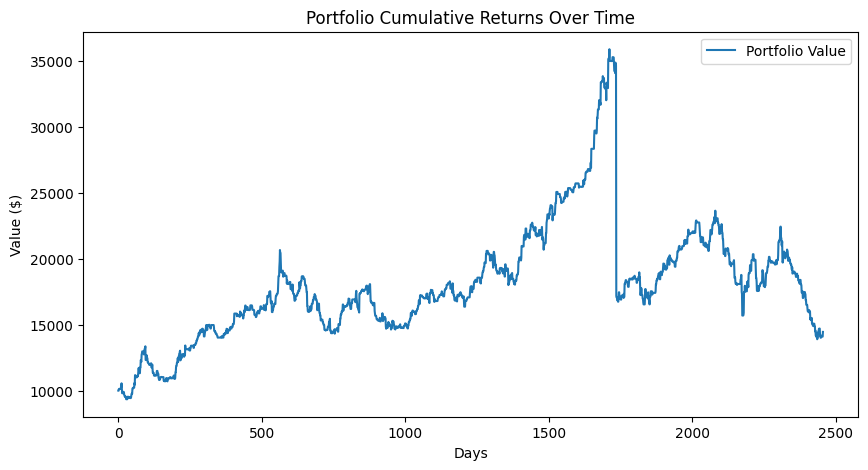

In [45]:
tests_agent_tcs(tdqn_agent, new_data_tcs)